In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "EIL"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn017871,MSNRMMMFDEMGFCGDLDFLSAPLGDGDVTASQTEPEAVVDDDYSD...,627,1
1,Achn018171,MDANGLDDNSDIEVDEIRCGNIVERDVSDEEIEAEDLERRMWKDRI...,638,1
2,Achn018431,MIMFDEMGFCGDLDFFSAPLGEGDMAAPQTEPEVVMDDDYSDEEID...,619,1
3,Achn123771,MGVMEEIGVDISSDIEVDEIRCENIAEKDVSDEEIEAEDLERRMWK...,608,1
4,Achn171621,MIELCEELNDPPSSDDEDDKLGYDELKKRIWKDRVRLQKLKAKHEA...,492,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
343,0.005164,0.0,0.000000,0.003442,0.000000,0.003442,0.0,0.003442,0.006885,0.001721,...,0.000000,0.001721,0.001721,0.003442,0.000000,0.001721,0.000000,0.000000,0.0,0.0
1108,0.000000,0.0,0.000000,0.004762,0.000000,0.000000,0.0,0.004762,0.004762,0.004762,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004762,0.000000,0.004762,0.0,0.0
904,0.006590,0.0,0.004942,0.006590,0.000000,0.001647,0.0,0.004942,0.004942,0.001647,...,0.001647,0.003295,0.000000,0.000000,0.001647,0.000000,0.000000,0.000000,0.0,0.0
2316,0.003058,0.0,0.003058,0.003058,0.003058,0.003058,0.0,0.000000,0.006116,0.000000,...,0.003058,0.003058,0.000000,0.000000,0.003058,0.000000,0.003058,0.000000,0.0,0.0
1022,0.002028,0.0,0.000000,0.002028,0.000000,0.002028,0.0,0.002028,0.004057,0.002028,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002028,0.000000,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1956, 441)
X_test: (489, 441)
y_train: (1956,)
y_test: (489,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 15s 638ms/step - accuracy: 0.5469 - loss: 0.6929

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5598 - loss: 0.6848 - val_accuracy: 0.9668 - val_loss: 0.6069


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9219 - loss: 0.6220

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9144 - loss: 0.5243 - val_accuracy: 0.9668 - val_loss: 0.1883


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.2092

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9519 - loss: 0.1848 - val_accuracy: 0.9923 - val_loss: 0.0454


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9219 - loss: 0.1627

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9685 - loss: 0.0859 - val_accuracy: 0.9923 - val_loss: 0.0329


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0652

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9837 - loss: 0.0645 - val_accuracy: 0.9949 - val_loss: 0.0222


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0146

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9886 - loss: 0.0424 - val_accuracy: 0.9974 - val_loss: 0.0175


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0274

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9915 - loss: 0.0346 - val_accuracy: 0.9949 - val_loss: 0.0184


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0130

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0302 - val_accuracy: 0.9821 - val_loss: 0.0437


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0466

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0245 - val_accuracy: 0.9847 - val_loss: 0.0220


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0100

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9928 - loss: 0.0313 - val_accuracy: 0.9974 - val_loss: 0.0144


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0043

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0198 - val_accuracy: 0.9974 - val_loss: 0.0151


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0059

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0118 - val_accuracy: 0.9974 - val_loss: 0.0101


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0859

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0200 - val_accuracy: 0.9974 - val_loss: 0.0095


Epoch 14/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0041

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0158 - val_accuracy: 0.9974 - val_loss: 0.0111


Epoch 15/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0600

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0171 - val_accuracy: 0.9974 - val_loss: 0.0135


Epoch 16/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0014

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0110 - val_accuracy: 0.9949 - val_loss: 0.0145



[Train Accuracy: 99.81% - Test Accuracy: 98.98%]


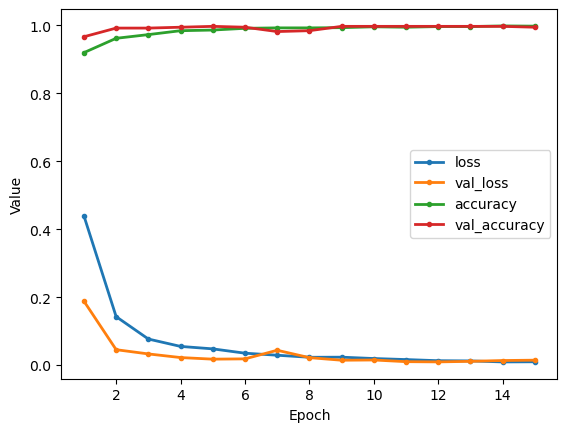

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
343,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.001724,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
904,0.0,0.0,0.0,0.00165,0.000000,0.0,0.0,0.001650,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2316,0.0,0.0,0.0,0.00000,0.003067,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.002033,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1956, 8587)
X_test: (489, 8587)
y_train: (1956,)
y_test: (489,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,198,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241,793 (8.55 MB)

 Trainable params: 2,241,793 (8.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 15s 644ms/step - accuracy: 0.5312 - loss: 0.6932

 8/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5192 - loss: 0.6931   

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6087 - loss: 0.6917

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6594 - loss: 0.6884

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6688 - loss: 0.6874 - val_accuracy: 0.9209 - val_loss: 0.6070


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9531 - loss: 0.5940

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8927 - loss: 0.5819 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9078 - loss: 0.5520

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9166 - loss: 0.5153

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9175 - loss: 0.5112 - val_accuracy: 0.9898 - val_loss: 0.1372


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.1216

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9923 - loss: 0.1022 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9933 - loss: 0.0864

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9933 - loss: 0.0759

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9934 - loss: 0.0750 - val_accuracy: 0.9923 - val_loss: 0.0230


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0094

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0071 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0067

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0066

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9988 - loss: 0.0066 - val_accuracy: 0.9949 - val_loss: 0.0113


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0017

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0027 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0026

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0024

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9991 - loss: 0.0024 - val_accuracy: 0.9949 - val_loss: 0.0101


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0017

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9974 - val_loss: 0.0115


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.3817e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2919e-04 

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5025e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6234e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.6054e-04 - val_accuracy: 0.9949 - val_loss: 0.0102


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.5526e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4802e-04 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8749e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0698e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0833e-04 - val_accuracy: 0.9949 - val_loss: 0.0108


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.1523e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2472e-04 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4820e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4488e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4448e-04 - val_accuracy: 0.9949 - val_loss: 0.0105


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.1865e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5650e-04 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3781e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2921e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2823e-04 - val_accuracy: 0.9949 - val_loss: 0.0113


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.4312e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9898e-05 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6735e-05

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0418e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0593e-04 - val_accuracy: 0.9949 - val_loss: 0.0113


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.4104e-05

 8/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1154e-04 

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1876e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2954e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3085e-04 - val_accuracy: 0.9949 - val_loss: 0.0122


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.9960e-05

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1620e-05 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6513e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9805e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.9916e-05 - val_accuracy: 0.9949 - val_loss: 0.0116


Epoch 14/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.9035e-05

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1962e-05 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4198e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8318e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9267e-05 - val_accuracy: 0.9949 - val_loss: 0.0112


Epoch 15/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.5276e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1185e-05 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7426e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9646e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9010e-05 - val_accuracy: 0.9974 - val_loss: 0.0129


Epoch 16/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.3912e-05

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8242e-05 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8968e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4743e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.5003e-05 - val_accuracy: 0.9949 - val_loss: 0.0116



[Train Accuracy: 100.00% - Test Accuracy: 99.59%]


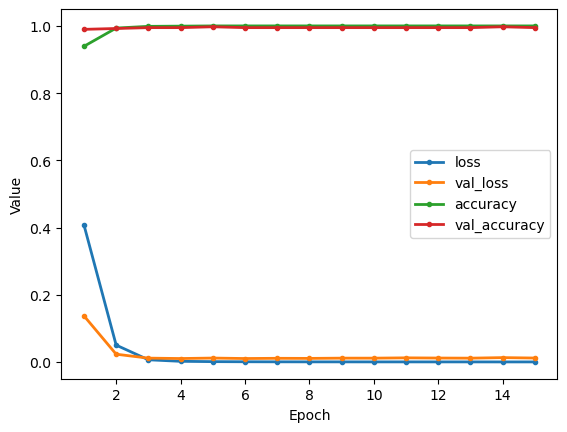

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      31,610,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,652,097 (120.74 MB)

 Trainable params: 31,652,097 (120.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 20s 864ms/step - accuracy: 0.3750 - loss: 0.6932

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4141 - loss: 0.6931  

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4392 - loss: 0.6930

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4486 - loss: 0.6930

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4532 - loss: 0.6930

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4558 - loss: 0.6931

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4583 - loss: 0.6930

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4594 - loss: 0.6930

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4631 - loss: 0.6930

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4696 - loss: 0.6929

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4778 - loss: 0.6929

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4869 - loss: 0.6928

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4959 - loss: 0.6927

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5047 - loss: 0.6926

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5139 - loss: 0.6925

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5232 - loss: 0.6924

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5323 - loss: 0.6922

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5410 - loss: 0.6921

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5490 - loss: 0.6919

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5562 - loss: 0.6917

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5631 - loss: 0.6915

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5698 - loss: 0.6913

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5764 - loss: 0.6911

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5828 - loss: 0.6908

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5889 - loss: 0.6906

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5945 - loss: 0.6903 - val_accuracy: 0.9745 - val_loss: 0.6526


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 1.0000 - loss: 0.6472

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9961 - loss: 0.6474 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9887 - loss: 0.6466

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9857 - loss: 0.6455

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9842 - loss: 0.6442

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9833 - loss: 0.6429

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9828 - loss: 0.6414

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9828 - loss: 0.6398

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9828 - loss: 0.6381

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9828 - loss: 0.6364

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9829 - loss: 0.6345

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9832 - loss: 0.6325

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9834 - loss: 0.6305

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9837 - loss: 0.6283

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9840 - loss: 0.6260

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9842 - loss: 0.6236

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9844 - loss: 0.6212

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9846 - loss: 0.6186

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9848 - loss: 0.6160

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9850 - loss: 0.6133

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9852 - loss: 0.6104

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9854 - loss: 0.6075

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9856 - loss: 0.6046

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9857 - loss: 0.6016

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9858 - loss: 0.5988

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9860 - loss: 0.5961 - val_accuracy: 0.9872 - val_loss: 0.3150


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9844 - loss: 0.3018

 2/25 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9805 - loss: 0.3024

 3/25 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9800 - loss: 0.3001

 4/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9811 - loss: 0.2960 

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9824 - loss: 0.2906

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9836 - loss: 0.2843

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9847 - loss: 0.2782

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9856 - loss: 0.2724

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9864 - loss: 0.2669

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9872 - loss: 0.2616

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9878 - loss: 0.2565

12/25 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9884 - loss: 0.2515

13/25 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9888 - loss: 0.2467

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9891 - loss: 0.2423

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9894 - loss: 0.2380

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9896 - loss: 0.2340

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9896 - loss: 0.2301

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9897 - loss: 0.2263

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9898 - loss: 0.2227

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9899 - loss: 0.2191

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9900 - loss: 0.2156

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9901 - loss: 0.2122

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9902 - loss: 0.2089

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9903 - loss: 0.2057

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9904 - loss: 0.2027

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9905 - loss: 0.2000 - val_accuracy: 0.9898 - val_loss: 0.0501


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 1.0000 - loss: 0.0170

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0168

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0169

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0172

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0171

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0170

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0167

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0166

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0163

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0161

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0158

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0156

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0154

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0151

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0149

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0147

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0145

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0143

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0140

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0139

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0137

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0135

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0133

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9999 - loss: 0.0132

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9999 - loss: 0.0130

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9999 - loss: 0.0129 - val_accuracy: 0.9898 - val_loss: 0.0313


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0034

 2/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0046 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.0047

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0047

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0047

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0045

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0044

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0043

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0043

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0042

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0041

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0041

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0040

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0040

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0039

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0039

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0038

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0038

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0037

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0037

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0036

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0036

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0036

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0035

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0035

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9898 - val_loss: 0.0370


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0010

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0011

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0011

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0011

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0012

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0012

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0012

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9898 - val_loss: 0.0345


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 8.1734e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.5526e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 7.5681e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 7.5407e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.4502e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.3549e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2842e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2650e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.3795e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.4393e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4786e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4902e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4955e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4887e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.4794e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 7.4561e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 7.4272e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 7.3970e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.3645e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.3279e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.2897e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 7.2490e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 7.2086e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 7.1710e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 7.1359e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 7.1034e-04 - val_accuracy: 0.9898 - val_loss: 0.0392


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 5.6502e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 6.0651e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.1526e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.2472e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.2317e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.4331e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.5037e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.4953e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.4404e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.3868e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 6.3217e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 6.2476e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 6.2112e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 6.1699e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 6.1216e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 6.0685e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 6.0237e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9887e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9554e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9193e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 5.8832e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 5.8448e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 5.8050e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 5.7712e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.7390e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 5.7094e-04 - val_accuracy: 0.9898 - val_loss: 0.0399


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 4.1509e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.6122e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.5259e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.6041e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.6751e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.7312e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 4.0919e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 4.3146e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.4454e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 4.5171e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 4.5540e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.5751e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.5768e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.5721e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.5632e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.5475e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.5268e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.5061e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.4823e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.4550e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.4383e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.4180e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.3969e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.3754e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.3546e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 4.3354e-04 - val_accuracy: 0.9898 - val_loss: 0.0356


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 1.6198e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.5882e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.5561e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.6084e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.7164e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.8024e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.8539e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.8834e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.8994e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.9105e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.9199e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9230e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.9246e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9287e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9307e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9300e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9311e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9314e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9300e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.9282e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.9276e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.9261e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.9221e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9216e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9205e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 1.9195e-04 - val_accuracy: 0.9898 - val_loss: 0.0412


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 5.0134e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 4.8290e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 4.4142e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 4.1071e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.8252e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.5946e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.4209e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 3.3141e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 3.2154e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 3.1327e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 3.0567e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 2.9942e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 2.9380e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 2.8821e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 2.8293e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 2.7775e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 2.7285e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 2.6848e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 2.6447e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 2.6071e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 2.5748e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 2.5463e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 2.5186e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 2.4934e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 2.4694e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 2.4473e-04 - val_accuracy: 0.9898 - val_loss: 0.0435


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 1.7803e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 1.4826e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 1.3839e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 1.5200e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 1.5631e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5688e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5626e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5553e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5589e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.5612e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.5617e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5632e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5631e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5627e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5584e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5529e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5491e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5464e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5428e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5384e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5345e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5307e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5321e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5320e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.5311e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 1.5303e-04 - val_accuracy: 0.9898 - val_loss: 0.0406


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 4.7632e-05

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 8.6006e-05

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 9.3728e-05

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.1581e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.2843e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.3790e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.4329e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.4575e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.4700e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.4706e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.4637e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4523e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4417e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4409e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4397e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4359e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4298e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4219e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4144e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.4064e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.3981e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.3911e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.3847e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.3779e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.3728e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 1.3680e-04 - val_accuracy: 0.9898 - val_loss: 0.0410



[Train Accuracy: 100.00% - Test Accuracy: 99.59%]


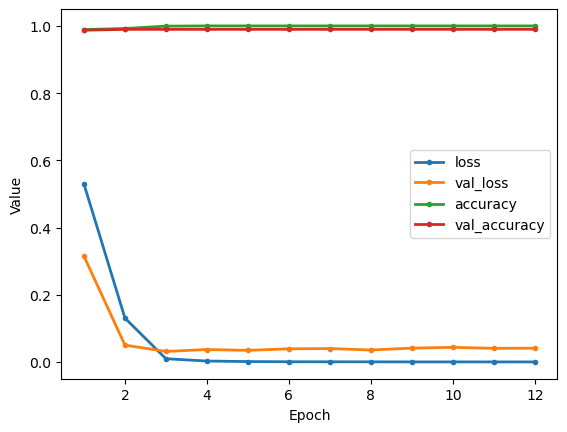

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/EIL/report_Z02D93LX.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################